In [1]:
import numpy as np
import numpy.linalg as LA
from scipy.integrate import quad
import ceo
import matplotlib.pyplot as plt
import json
import sys
import time
from IPython.display import display, clear_output
%matplotlib inline

In [2]:
import ceo.ActiveOptics as AcO

# PARAMETERS

* Pupil size

In [3]:
pupil_size = 25.5

- atmosphere or not

In [4]:
WITH_ATMOSPHERE = False

* diffractive or geometric TT7

In [5]:
#TT7_CLASS = "TT7" # diffractive model
TT7_CLASS = "GeometricTT7" # geometric model

 - initial segments misalignment or not

In [6]:
WITH_MISALIGNMENT = True
if WITH_MISALIGNMENT:
    TT7_CLASS = "GeometricTT7"

## GMT

In [7]:
gmt_prms = {'M1_mirror_modes':u"bending modes",'M1_N_MODE':42}

## Optical paths

### On-axis imager

In [8]:
if WITH_ATMOSPHERE:
    on_axis_imgr = {'N_SIDE_LENSLET':1,"N_PX_PUPIL":511,
                   'N_PX_IMAGE':1001}
else:
    on_axis_imgr = {'N_SIDE_LENSLET':1,"N_PX_PUPIL":255,
                   'DFT_osf':4,'N_PX_IMAGE':401}    
on_axis_src = {'photometric_band':"V",'zenith':[0],'azimuth':[0],'height':float('inf'),
               'fwhm':0,'magnitude':0,'rays_box_size':pupil_size,
               'rays_box_sampling':on_axis_imgr['N_PX_PUPIL']+1,'rays_origin':[0,0,25]}

### WFSs

In [9]:
wfs_nLenslet = 48
wfs_prms = {'N_SIDE_LENSLET':wfs_nLenslet,"N_PX_LENSLET":16,'d':pupil_size/wfs_nLenslet,
           'DFT_osf':2,'N_PX_IMAGE':24,'BIN_IMAGE':3,'N_GS': 3,
           'readOutNoiseRms':0.5,'noiseFactor':np.sqrt(2),
           'photoElectronGain':0.63, 'exposureTime':30,
           'intensityThreshold':0.0}

zen = np.ones(3)*ceo.constants.ARCMIN2RAD*6
azi = np.arange(3)*2*np.pi/3
wfs_guide_stars = {'photometric_band':"R+I",'zenith':zen.tolist(),'azimuth':azi.tolist(),'height':float('inf'),
               'fwhm':0,'magnitude':[14,14,14],'rays_box_size':pupil_size,
               'rays_box_sampling':wfs_prms['N_SIDE_LENSLET']*wfs_prms['N_PX_LENSLET']+1,'rays_origin':[0,0,25]}

### TT7

In [10]:
tt7_prms = {"N_PX_LENSLET":1023,'d':pupil_size,
           'N_PX_IMAGE':142*5,'BIN_IMAGE':142,
            'readOutNoiseRms':0.5,'photoElectronGain':0.66}

zen = ceo.constants.ARCMIN2RAD*6
azi = np.pi
tt7_guide_star = {'photometric_band':"R+I",'zenith':zen,'azimuth':azi,'height':float('inf'),
               'fwhm':0,'magnitude':14,'rays_box_size':pupil_size,
               'rays_box_sampling':tt7_prms['N_PX_LENSLET']+1,'rays_origin':[0,0,25]}

## Atmosphere

In [11]:
r0 = 12.8e-2 
r0_wavelength = 500e-9
if WITH_ATMOSPHERE:
    atm_prms = dict(jsonfile='/mnt/bins/gmtAtmosphereL030.json',
                    zipdata='s3://gmto.rconan/gmtAtmosphereL030.zip',
                    cache='/mnt/bins/')
else:
    atm_prms = {}

## JSON parameter files

In [12]:
config = {'GMT':gmt_prms, 
          'ON_AXIS_SRC':on_axis_src, 'ON_AXIS_IMGR':on_axis_imgr,
          'WFS_GUIDE_STARS': wfs_guide_stars, 'WFS':wfs_prms,
          'TT7_GUIDE_STAR': tt7_guide_star, 'TT7':tt7_prms,
          'ATMOSPHERE':atm_prms}

In [13]:
for key in config:
    with open(key+'.json', 'w') as outfile:
        print ">>> "+outfile.name
        json.dump(config[key], outfile, sort_keys = False, indent = 4, ensure_ascii=False)

>>> ON_AXIS_SRC.json
>>> ATMOSPHERE.json
>>> WFS_GUIDE_STARS.json
>>> WFS.json
>>> ON_AXIS_IMGR.json
>>> TT7_GUIDE_STAR.json
>>> TT7.json
>>> GMT.json


# OBJECT DEFINITIONS

In [14]:
gmt = ceo.GMT_MX(**gmt_prms)

In [15]:
gs0 = ceo.Source(**on_axis_src)
imgr = ceo.Imaging(**on_axis_imgr)

In [16]:
gs = ceo.Source(**wfs_guide_stars)
wfs = ceo.ShackHartmann(**wfs_prms)

In [17]:
tt7_gs = ceo.Source(**tt7_guide_star)
if TT7_CLASS=='TT7':
    tt7 = ceo.TT7(**tt7_prms)
if TT7_CLASS=='GeometricTT7':
    tt7 = ceo.GeometricTT7()

In [18]:
if WITH_ATMOSPHERE:
    atm = ceo.JGmtAtmosphere(**atm_prms)
    atm.r0 = r0
    gs0.timeStamp = 0
    gs0>>(atm,)
    +gs0
    plt.imshow(gs0.phase.host(units='nm'),interpolation='none',cmap='viridis')
    plt.colorbar()
else:
    atm = None

# CALIBRATION

## WFSs

Seeing conversion to FWHM in detector pixel (before binning):

In [19]:
_r0_ = r0*(gs.wavelength/r0_wavelength)**1.2
seeingArcsec = gs.wavelength/_r0_*ceo.constants.RAD2ARCSEC
print "WFS seeing: %.2farcsec"%seeingArcsec
gs_fwhm = round(seeingArcsec/(wfs.camera.pixelScaleArcsec(gs)/wfs.BIN_IMAGE))
print "WFS FWHM: %d pixel"%gs_fwhm
gs.fwhm = gs_fwhm

WFS seeing: 0.75arcsec
WFS FWHM: 5 pixel


### Reference slopes

In [20]:
gs.reset()
gmt.reset()
gmt.propagate(gs)
wfs.calibrate(gs,0.)
print wfs.n_valid_lenslet

6912


In [21]:
print "detector resolution: %dpixel"%wfs.N_PX_FRAME
print "WFS pixel scale:  %.2farcsec"%wfs.pixel_scale_arcsec
print "WFS field-of-view %.2farcsec"%(wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/wfs.BIN_IMAGE)

detector resolution: 384pixel
WFS pixel scale:  0.42arcsec
WFS field-of-view 3.33arcsec


###  Interaction matrix (decoupled)

In [47]:
includeBM = True

In [48]:
%%time
gwfs = ceo.GeometricShackHartmann(wfs_nLenslet,pupil_size/wfs_nLenslet,N_GS=gs.N_SRC)
gs.reset()
gmt.reset()
gmt.propagate(gs)
gwfs.calibrate(gs,0.)

C = gmt.AGWS_calibrate(gwfs,gs,decoupled=True,fluxThreshold=0.5,includeBM=includeBM,
                       filterMirrorRotation=True,
                      calibrationVaultKwargs={'nThreshold':[2]*6+[0],
                                              'insertZeros':[None]*6 + [[2,7]]})

___ M1 ___ (Rxyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M2 ___ (Rxyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M1 ___ (Txyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M2 ___ (Txyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M1 ___ (bending modes)
Segment #0: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
Segment #1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
Segment #2: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
Segment #3: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
Segment #4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
Segment #5: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 

The following cell allows to save and to load the WFS interaction matrix

<a list of 12 Text yticklabel objects>


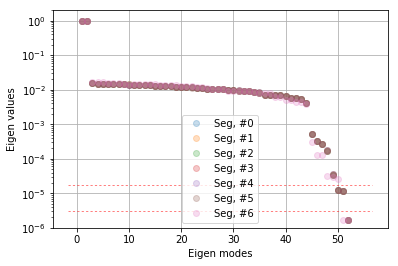

In [54]:
for k in range(7):
    plt.semilogy(range(1,np.size(C.eigenValues[k])+1),C.eigenValues[k]/C.eigenValues[k][0],'o',alpha=0.25,label='Seg, #%d'%k)
    #plt.semilogy(C.eigenValues[k][40:]/C.eigenValues[k][0],'o',alpha=0.25,label='Seg, #%d'%k)
plt.grid()
ax = plt.gca()
xlim =  ax.get_xlim()
yticks =  ax.get_yticks()
yticklabels = ax.get_yticklabels()
print yticklabels
#plt.yticks( np.sort( np.append( yticks, 10**np.array([-5.5, -4.5]) ) ) )
plt.plot(xlim,[10**-6.5]*2,'r:',alpha=0.5,linewidth=1)
plt.plot(xlim,[10**-5.5]*2,'r:',alpha=0.5,linewidth=1)
plt.plot(xlim,[10**-4.75]*2,'r:',alpha=0.5,linewidth=1)
plt.legend(loc=0)
plt.xlabel('Eigen modes')
plt.ylabel('Eigen values')
h = plt.ylim([1e-6,2])
#ax.set_yticklabels(yticklabels)

In [53]:
C.threshold = 10**-4.75
C.nThreshold

@(CalibrationMatrix)> Updating the pseudo-inverse...


[5, 5, 5, 5, 5, 5, 2]

### Filtering mirror clocking (alternative)

## Linear LSQ Active Optics 

In [43]:
%%time
%%capture AcO_log
lsq_aco = AcO.LSQ(gmt_prms,tt7_guide_star,wfs_guide_stars,wfs_prms,
                  includeBM=includeBM,filename='ActiveOpticsWM1S1Tz')

CPU times: user 8.84 s, sys: 2.43 s, total: 11.3 s
Wall time: 6.52 s


In [34]:
lsq_aco.WFE(10**-6.5,gs_wfs_mag=14,
            spotFWHM_arcsec=seeingArcsec,
            pixelScale_arcsec=wfs.pixel_scale_arcsec,
            nPhBackground=70,controller={'T':30,'tau':1,'g':0.5})


@(CalibrationMatrix)> Updating the pseudo-inverse...
@(wfsNoise)> Closed-loop noise rejection factor: 0.2972


In [35]:
lsq_aco.noise_free_wfe

1.2010670619267805

In [36]:
A = 0.5*(lsq_aco.Cov_wo_noise[0]+lsq_aco.Cov_wo_noise[0].T)

In [37]:
L = LA.cholesky(lsq_aco.N2[0])

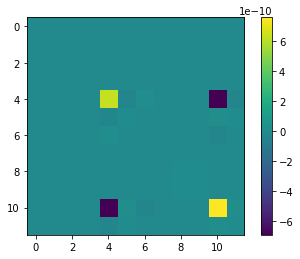

In [39]:
plt.imshow(lsq_aco.N2[0][:12,:12])
plt.colorbar()

In [24]:
lsq_aco.Osp[-1].shape

(5636, 54)

In [31]:
n = lsq_aco.Os[0].shape[0]
Z1 = np.ones((n,1))/np.sqrt(n)
Q1 = np.eye(n) - np.dot(Z1,Z1.T)
A = Q1.dot(Q1,lsq_aco.Osp)

In [35]:
Z1.shape

(5636, 1)

In [40]:
lsq_aco.piston_removed = True

In [55]:
%%time
%%capture AcO_WFE_log
mags = np.arange(10,21)
threshold = 10**np.array([-6.5,-5.5,-4.75])
lin_wfe_rms0 = np.zeros(3)
lin_wfe_rms = np.zeros((mags.size,3))
lin_wfe_noise_rms = np.zeros((mags.size,3))
for k in range(3):
    for kMags in range(mags.size):
        lsq_aco.WFE(threshold[k],gs_wfs_mag=mags[kMags],
                    spotFWHM_arcsec=seeingArcsec,
                    pixelScale_arcsec=wfs.pixel_scale_arcsec,
                    nPhBackground=70,controller={'T':30,'tau':1,'g':0.5})
        lin_wfe_rms0[k] = lsq_aco.noise_free_wfe
        lin_wfe_rms[kMags,k] = lsq_aco.wfe_rms
        lin_wfe_noise_rms[kMags,k] = lsq_aco.wfe_noise_rms

CPU times: user 4min 32s, sys: 40.7 s, total: 5min 13s
Wall time: 1min 18s


In [56]:
all_data = {}
data_file = 'results'
if includeBM:
    data_file = 'results_wBM'
    
for k in range(10):
    results = np.load('%s%d.npy'%(data_file,k+1))

    keys = results[()].keys()
    keys.sort()

    data = []
    for key in keys:
        #print key
        batch_wfs_rms = results[()][key]
        #print [np.sqrt(np.mean(x[200:]**2))  for x in batch_wfs_rms]
        data += [np.sqrt(np.mean(x[200:]**2))  for x in batch_wfs_rms]

    all_data[k] = np.array(data).reshape(4,-1)
#print all_data

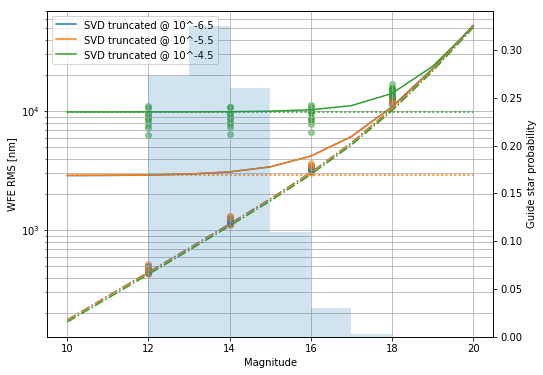

In [57]:
#ax.figure(figsize=(8,6))
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

tax = ax.twinx()
asts = np.loadtxt('asterisms_agws',delimiter=',')
h_mag = tax.hist(asts[:,2],10,[10,20],alpha=0.2, normed=1)
tax.set_ylabel('Guide star probability')


ax.semilogy(mags,lin_wfe_rms)
h = ax.semilogy(mags,lin_wfe_noise_rms,'-.',label='Noise')
[h[k].set_color('C%d'%k) for k in range(3)]
#ax.plot([10,20],[lin_wfe_rms0[0]]*2,'C0--')
ax.plot([10,20],[lin_wfe_rms0[1]]*2,'C1:')
ax.plot([10,20],[lin_wfe_rms0[2]]*2,'C2:')
#ax.scatter([12,14,16,18],[38,92,287,1028],c='C0',marker='.',alpha=0.5)
#ax.scatter([12,14,16,18],[96,109,212,728],c='C1',marker='.',alpha=0.5)
#ax.scatter([12,14,16,18],[1635,1666,1630,1810],c='C2',marker='.',alpha=0.5)

for ii in range(10):
    for k in range(3):
        ax.scatter([12,14,16,18],all_data[ii][:,k],c='C%d'%k,s=35,marker='o',alpha=0.5)

ax.grid(which='both')
ax.set_xlabel('Magnitude')
ax.set_ylabel('WFE RMS [nm]')

ax.legend(['SVD truncated @ 10^-6.5','SVD truncated @ 10^-5.5','SVD truncated @ 10^-4.5'])

In [30]:
lin_wfe_rms0

array([  1.20106706e+00,   6.39968241e+01,   9.41102984e+03])

In [27]:
lin_wfe_rms0

array([  1.11058270e+00,   5.91748805e+01,   8.70035326e+03])

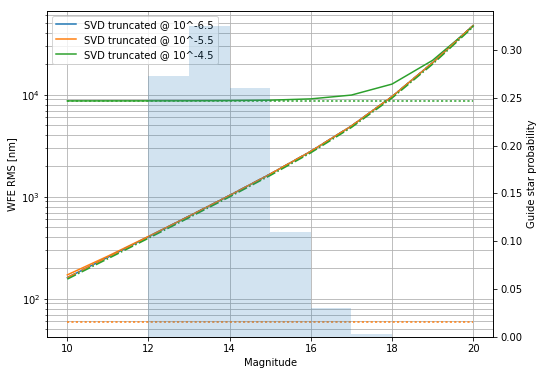

In [29]:
show_e2e = False
#ax.figure(figsize=(8,6))
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

tax = ax.twinx()
asts = np.loadtxt('asterisms_agws',delimiter=',')
h_mag = tax.hist(asts[:,2],10,[10,20],alpha=0.2, normed=1)
tax.set_ylabel('Guide star probability')


ax.semilogy(mags,lin_wfe_rms)
h = ax.semilogy(mags,lin_wfe_noise_rms,'-.',label='Noise')
[h[k].set_color('C%d'%k) for k in range(3)]
#ax.plot([10,20],[lin_wfe_rms0[0]]*2,'C0--')
ax.plot([10,20],[lin_wfe_rms0[1]]*2,'C1:')
ax.plot([10,20],[lin_wfe_rms0[2]]*2,'C2:')

if show_e2e:
    #ax.scatter([12,14,16,18],[38,92,287,1028],c='C0',marker='.',alpha=0.5)
    #ax.scatter([12,14,16,18],[96,109,212,728],c='C1',marker='.',alpha=0.5)
    #ax.scatter([12,14,16,18],[1635,1666,1630,1810],c='C2',marker='.',alpha=0.5)

    for ii in range(10):
        for k in range(3):
            ax.scatter([12,14,16,18],all_data[ii][:,k],c='C%d'%k,s=35,marker='o',alpha=0.5)

ax.grid(which='both')
ax.set_xlabel('Magnitude')
ax.set_ylabel('WFE RMS [nm]')

ax.legend(['SVD truncated @ 10^-6.5','SVD truncated @ 10^-5.5','SVD truncated @ 10^-4.5'])

## Reference slopes covariance

In [24]:
gwfs = ceo.GeometricShackHartmann(wfs_nLenslet,pupil_size/wfs_nLenslet,N_GS=3)

In [25]:
wfs_guide_stars

{'azimuth': [0.0, 2.0943951023931953, 4.1887902047863905],
 'fwhm': 0,
 'height': inf,
 'magnitude': [14, 14, 14],
 'photometric_band': 'R+I',
 'rays_box_sampling': 769,
 'rays_box_size': 25.5,
 'rays_origin': [0, 0, 25],
 'zenith': [0.0017453292519943294,
  0.0017453292519943294,
  0.0017453292519943294]}

OPTICAL PATH: ['GMT_MX', 'GeometricShackHartmann']


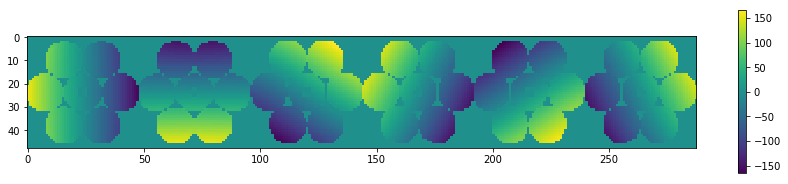

In [26]:
off_axis0 = wfs_guide_stars
#off_axis0['zenith'] = ceo.constants.ARCMIN2RAD*8.5
off_axis0['rays_box_sampling'] = wfs_nLenslet*8+1
src0 = ceo.Source(**off_axis0)

~gmt
gwfs.reset()
src0>>(gmt,gwfs)
+src0
gwfs.process()
s0 = gwfs.c.host(shape=(2*wfs_nLenslet*3,wfs_nLenslet),units='mas')
m0 = s0!=0

plt.figure(figsize=(15,3))
plt.imshow(s0.T)
plt.colorbar()

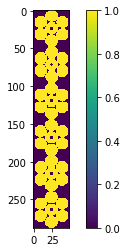

In [27]:
plt.imshow(m0)
plt.colorbar()

In [28]:
off_axis0['zenith'][0]*ceo.constants.RAD2ARCMIN

6.0

OPTICAL PATH: ['GMT_MX', 'GeometricShackHartmann']


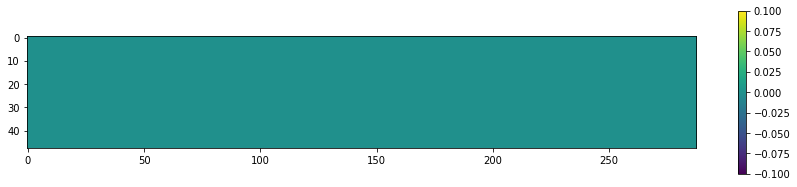

In [29]:
off_axis1 = wfs_guide_stars
off_axis1['zenith'] = [x + ceo.constants.MAS2RAD*500*0 for x in off_axis0['zenith']]
#off_axis1['azimuth'] = ceo.constants.MAS2RAD*1000
off_axis1['rays_box_sampling'] = wfs_nLenslet*8+1
src1 = ceo.Source(**off_axis1)

~gmt
src1>>(gmt,gwfs)

gwfs.reset()
src1.reset()
gmt.reset()
gmt.propagate(src1)
gwfs.analyze(src1)
s1 = gwfs.c.host(shape=(2*wfs_nLenslet*3,wfs_nLenslet),units='mas')
m1 = s1!=0
delta_s = m1*m0*(s1-s0)

plt.figure(figsize=(15,3))
plt.imshow(delta_s.T,interpolation='none')
plt.colorbar()

### Reference slopes covariance estimate

In [118]:
%%time
gwfs = ceo.GeometricShackHartmann(wfs_nLenslet,pupil_size/wfs_nLenslet,N_GS=3)
nSample = 800
~gmt
eps = lambda: np.random.randn()*0.5/3*ceo.constants.ARCSEC2RAD
delta_s = np.zeros((wfs_nLenslet*6*wfs_nLenslet,nSample))
check = np.zeros(nSample)
off_axis0 = dict(**wfs_guide_stars)
off_axis0['rays_box_sampling'] = wfs_nLenslet*8+1
src1 = ceo.Source(**off_axis0)
~gmt
gmt.propagate(src1)
gwfs.calibrate(src1,0.0)
for kSample in range(nSample):
    off_axis1 = dict(**wfs_guide_stars)
    off_axis1['zenith'] = [x + eps() for x in off_axis0['zenith']]
    off_axis1['azimuth'] = [x + eps() for x in off_axis0['azimuth']]
    src1.updateDirections(np.array(off_axis1['zenith'],dtype=np.single),
                          np.array(off_axis1['azimuth'],dtype=np.single))
    check[kSample] = eps()
    src1.reset()
    gmt.propagate(src1)
    gwfs.reset()
    gwfs.analyze(src1)
    s1 = gwfs.valid_slopes.host(units='mas').ravel()
    delta_s[:,kSample] = s1
print np.std(check)*ceo.constants.RAD2ARCSEC*3

0.507937109954
CPU times: user 41.1 s, sys: 25 s, total: 1min 6s
Wall time: 1min 6s


In [119]:
mean__delta_s = np.mean(delta_s,1)
print mean__delta_s.shape
zero_mean__delta_s = delta_s - mean__delta_s[:,None]
print zero_mean__delta_s.shape

(13824,)
(13824, 800)


In [120]:
V = lsq_aco.C.valid
V[6].shape

(13824, 1)

In [121]:
zero_mean__delta_s[V[0].ravel(),:].shape

(1094, 800)

(940, 940)


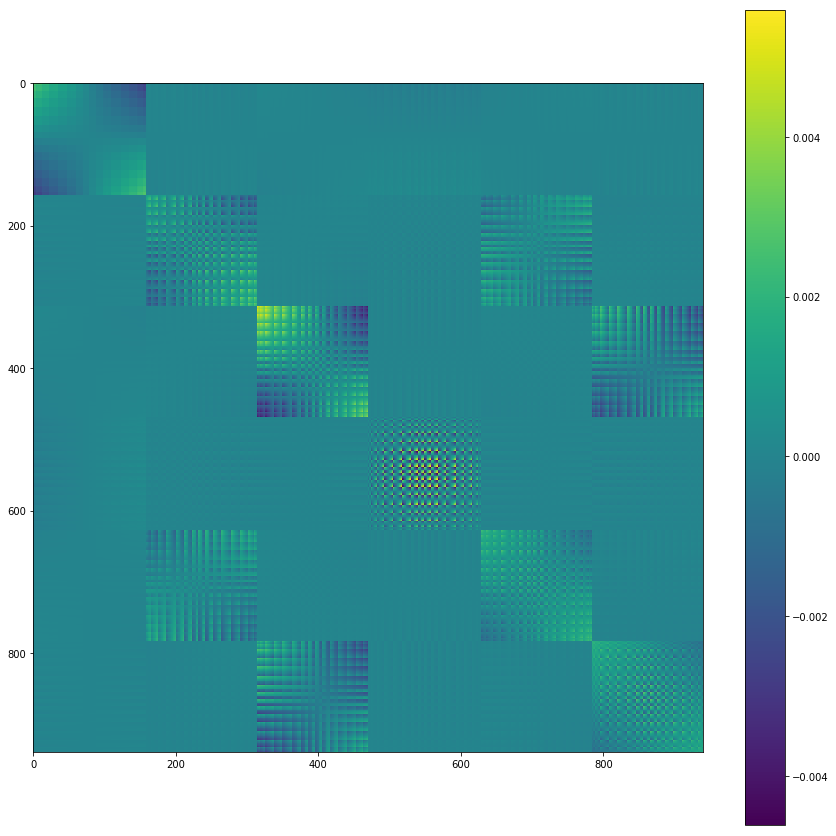

In [131]:
segId1 = 6
segment1__zero_mean__delta_s = zero_mean__delta_s[V[segId1].ravel(),:]
segId2 = 6
segment2__zero_mean__delta_s = zero_mean__delta_s[V[segId1].ravel(),:]

cov__delta_s = np.dot(segment1__zero_mean__delta_s,
                      segment2__zero_mean__delta_s.T)/nSample
print cov__delta_s.shape

plt.figure(figsize=(15,15))
plt.imshow(cov__delta_s,interpolation='none')
plt.colorbar()

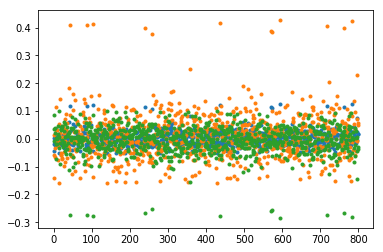

In [123]:
plt.plot(delta_s[100*10,:],'.')
plt.plot(delta_s[30*20,:],'.')
plt.plot(delta_s[50*30,:],'.')

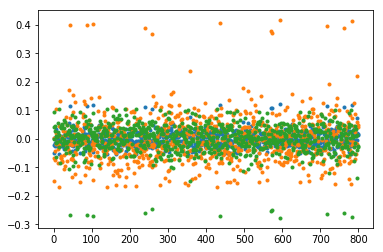

In [124]:
plt.plot(zero_mean__delta_s[100*10,:],'.')
plt.plot(zero_mean__delta_s[30*20,:],'.')
plt.plot(zero_mean__delta_s[50*30,:],'.')

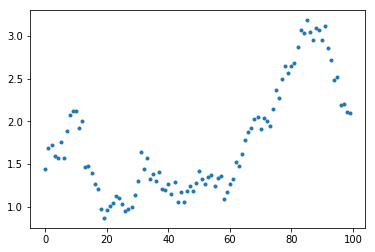

In [48]:
plt.plot(np.max(np.abs(delta_s),axis=(0,1)),'.')

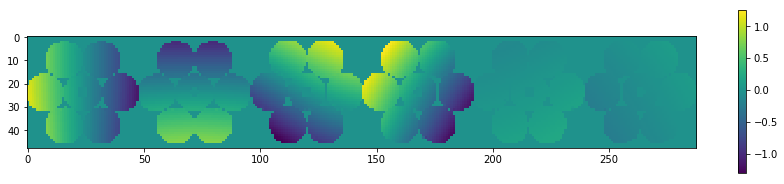

In [50]:
plt.figure(figsize=(15,3))
plt.imshow(delta_s[:,:,30].T,interpolation='none')
plt.colorbar()

In [36]:
off_axis1['azimuth']

[6.349594629243282e-07, 2.094395725716539, 4.188790895574173]

In [39]:
off_axis_src = on_axis_src
off_axis_src['zenith'] = 

In [34]:
eps()

6.922323029164144e-07

# WFS

OPTICAL PATH: ['GMT_MX', 'ShackHartmann']
WFS lenslet flux       : 139201.61
# of photon per lenslet: 130471.65
Numerical centroid rms error  : 1.52mas
Theoretical centroid rms error: 1.76mas


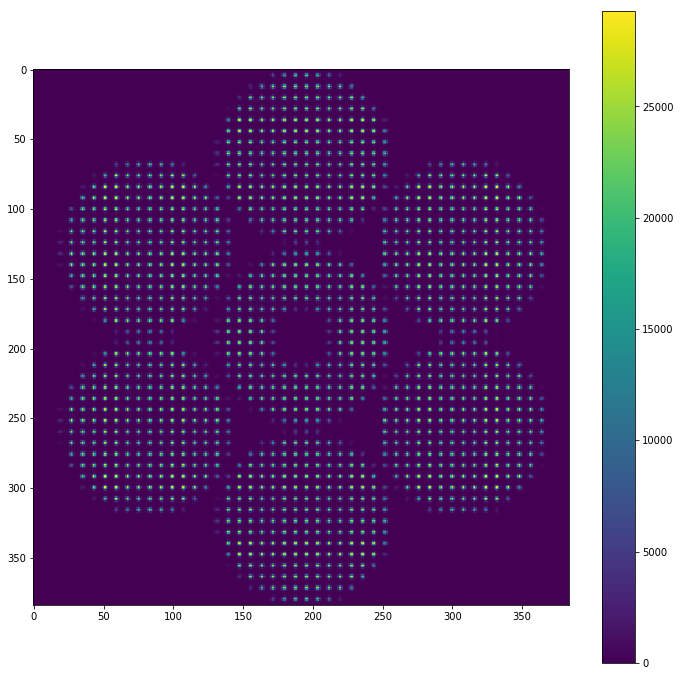

In [58]:
wfs.camera.exposureTime = 30
gs.magnitude = [15]*3
~gmt
~wfs
gs>>(gmt,wfs)
+gs
+wfs
fig = plt.figure()
fig.set_size_inches(12,12)
plt.imshow(wfs.camera.ghost_frame[:wfs.N_PX_FRAME,:],interpolation='none',cmap='viridis')
plt.colorbar()

flux = wfs.flux.host()
print "WFS lenslet flux       : %.2f"%(np.median(flux[flux>0]))
nPhLenslet = wfs.camera.exposureTime*wfs.camera.photoelectron_gain*gs.nPhoton[0]*(25.5/48)**2
print "# of photon per lenslet: %.2f"%(nPhLenslet)

s = wfs.valid_slopes.host(units='mas').ravel()
print "Numerical centroid rms error  : %.2fmas"%(np.std(np.concatenate([s[X.ravel()] for X in C.valid])))
print "Theoretical centroid rms error: %.2fmas"%(1e3*seeingArcsec/np.sqrt(2*np.log(2)*nPhLenslet))

WFS frame read-out noise: 0.501


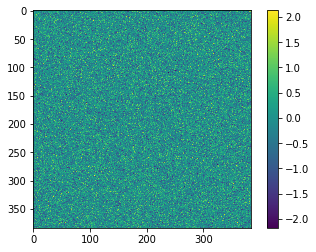

In [59]:
~wfs
+wfs
fig = plt.figure()
plt.imshow(wfs.camera.ghost_frame[:wfs.N_PX_FRAME,:],interpolation='none',cmap='viridis')
plt.colorbar()
print "WFS frame read-out noise: %.3f"%np.std(wfs.camera.ghost_frame)

Expected # of background photons: 5186050
Measured # of background photons: 5188449


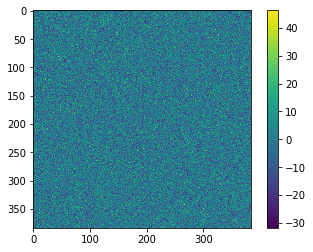

In [60]:
backgroundMagnitude = 16.8
wfs.camera.nBackgroundPhoton = gs.nBackgroundPhoton(backgroundMagnitude)*wfs.camera.pixelScaleArcsec(gs)**2
~wfs
+gs
+wfs
~wfs
+wfs
fig = plt.figure()
plt.imshow(wfs.camera.ghost_frame[:wfs.N_PX_FRAME,:],interpolation='none',cmap='viridis')
plt.colorbar()

print "Expected # of background photons: %.0f"%(gs.nBackgroundPhoton(backgroundMagnitude)*\
                                          wfs.camera.pixelScaleArcsec(gs)**2*\
                                          wfs.camera.exposureTime*wfs.camera.photoelectron_gain)
print  "Measured # of background photons: %.0f"%(np.var(wfs.camera.ghost_frame/wfs_prms['noiseFactor'])*wfs.N_PX_FRAME**2)

In [61]:
np.var(wfs.camera.ghost_frame)

70.372841

## TT7

Seeing conversion to FWHM in detector pixel (before binning):

In [62]:
if TT7_CLASS=='TT7':
    _r0_ = r0*(tt7_gs.wavelength/r0_wavelength)**1.2
    seeingArcsec = tt7_gs.wavelength/_r0_*ceo.constants.RAD2ARCSEC
    print "TT7 seeing: %.2farcsec"%seeingArcsec
    pxscl = tt7.camera.pixelScaleArcsec(tt7_gs)
    tt7_gs_fwhm = round(seeingArcsec/(pxscl/tt7.BIN_IMAGE))
    print "WFS FWHM: %d pixel"%tt7_gs_fwhm
    tt7_gs.fwhm = tt7_gs_fwhm

    print "detector resolution: %dpixel"%tt7.N_PX_FRAME
    print "WFS pixel scale:  %.2farcsec"%pxscl
    print "WFS field-of-view %.2farcsec"%(pxscl*tt7.N_PX_IMAGE/tt7.BIN_IMAGE)

### Reference slopes

In [63]:
gmt.reset()
gmt.propagate(tt7_gs)
tt7.calibrate(tt7_gs)

### Interaction matrix

In [64]:
%%time
Dtt7 = gmt.calibrate(tt7,tt7_gs,mirror = 'M2',mode='segment tip-tilt',stroke=1e-6)
print Dtt7.shape
print LA.cond(Dtt7)
Mtt7 = LA.inv(Dtt7)

___ M2 ___ (segment tip-tilt)
Segment #:1 2 3 4 5 6 7 
------------
(14, 14)
1.03266798619
CPU times: user 3.08 s, sys: 1.78 s, total: 4.86 s
Wall time: 4.86 s


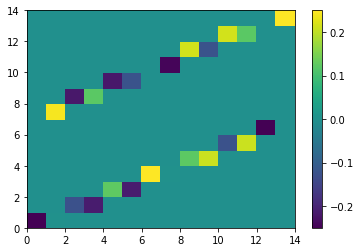

In [65]:
plt.pcolor(Dtt7)
plt.colorbar()

In [66]:
if TT7_CLASS=='TT7':
    tt7_gs.fwhm = tt7_gs_fwhm
    tt7_gs>>(gmt,tt7,)
    ~gmt
    ~tt7
    +tt7_gs
    +tt7
    print np.array_str(tt7.get_measurement()*ceo.constants.RAD2ARCSEC,precision=3,suppress_small=True)
    fig = plt.figure()
    fig.set_size_inches(15,4)
    plt.imshow(tt7.ghost_frame.T,interpolation='none',cmap='viridis')
    #plt.imshow(tt7.frames[:,:,k],interpolation='none',cmap='viridis')
    plt.colorbar(orientation='horizontal')

    #print "WFS total flux     : %.2f"%tt7.frames.sum()
    flux = tt7.flux.host()
    print "WFS lenslet flux   : %.2f"%(np.sum(flux))
    print "# of photon per sec: %.2f"%(tt7.camera.photoelectron_gain*tt7_gs.nPhoton*357)

In [67]:
if WITH_ATMOSPHERE:
    tt7_gs.timeStamp = 0
    tt7_gs.fwhm = 0
    tt7_gs>>(atm,gmt,tt7,)
    ~gmt
    ~tt7
    +tt7_gs
    +tt7
    print np.array_str(tt7.get_measurement()*ceo.constants.RAD2ARCSEC,precision=3,suppress_small=True)
    fig = plt.figure()
    ext = np.array([-1,1,-1,1])*tt7.N_PX_FRAME/2*tt7.pixel_scale_arcsec
    plt.imshow(tt7.ghost_frame[:tt7.N_PX_FRAME,:],interpolation='none',cmap='viridis',extent=ext)
    plt.colorbar()
    #plt.xticks(range(-8,10,2))
    #plt.yticks(range(-8,10,2))
    plt.grid(color='w')
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')

# ON AXIS IMAGER

OPTICAL PATH: ['GMT_MX', 'Imaging']
detector resolution: 401pixel
WFS pixel scale:  1.11mas
WFS field-of-view 0.45arcsec
EE80: 26.69mas


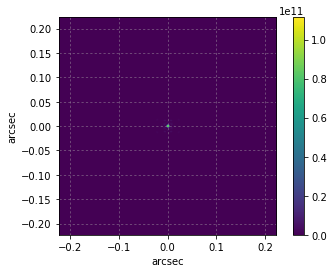

In [68]:
gs0>>(gmt,imgr)
~gmt
~imgr
+gs0
print "detector resolution: %dpixel"%imgr.N_PX_FRAME
print "WFS pixel scale:  %.2fmas"%(imgr.pixelScaleArcsec(gs0)*1e3)
print "WFS field-of-view %.2farcsec"%(imgr.pixelScaleArcsec(gs0)*imgr.N_PX_IMAGE/imgr.BIN_IMAGE)
ext = np.array([-1,1,-1,1])*imgr.N_PX_FRAME*0.5*imgr.pixelScaleArcsec(gs0)
plt.imshow(imgr.frame.host(),interpolation='None',cmap='viridis',extent=ext)
plt.colorbar()
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.grid(ls='dotted',alpha=0.5)
ee80_0 = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()
print "EE80: %.2fmas"%ee80_0

In [69]:
if WITH_ATMOSPHERE:
    gs0>>(atm,gmt,imgr)
    gs0.timeStamp = 0
    ~gmt
    ~imgr
    +gs0
    plt.imshow(imgr.frame.host(),interpolation='None',cmap='viridis',extent=ext)
    plt.colorbar()
    plt.grid(color='w')
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    ee80_atm = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()
    print "EE80: %.2fmas"%ee80_atm

In [69]:
%%time
if WITH_ATMOSPHERE:
    nStep = 200
    ps0_rms_0 = np.zeros(nStep)
    gmt0 = ceo.GMT_MX()
    ~imgr
    gs0>>(atm,gmt0,imgr)
    gs0.timeStamp = 0
    for k in range(nStep):
        +gs0
        ps0_rms_0[k] = gs0.wavefront.rms(-9)

    psf_atm_0 = imgr.frame.host()
    ee80_atm_0 = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()
    print "EE80: %.2fmas"%ee80_atm_0
    
    plt.imshow(imgr.frame.host(),interpolation='None',cmap='viridis',extent=ext)
    plt.colorbar()
    plt.grid(color='w')
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    print "Guide star time stamp:%gs"%gs0.timeStamp

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


# AGWS CLOSED-LOOP

In [70]:
def updateGMT(__c__,_dist_,__tt7_c__=0.0):
    _s_ = np.s_[:]
    l = 12+gmt.M1.modes.n_mode*includeBM
    cp = np.reshape(__c__,(7,l))
    gmt.M1.motion_CS.update(Rxyz=(_s_,_s_,_dist_[0] - cp[:,:3]),
                            Txyz=(_s_,_s_,_dist_[2] - cp[:,3:6]))
    gmt.M2.motion_CS.update(Rxyz=(_s_,_s_,_dist_[1] - __tt7_c__ - cp[:,6:9]),
                            Txyz=(_s_,_s_,_dist_[3] - cp[:,9:12]))
    if includeBM:
        gmt.M1.modes.a[:] = _dist_[4] - cp[:,12:]
        gmt.M1.modes.update()

In [71]:
from numpy.random import randn
np.random.seed(465)
def perturbations():
    M1_Txyz0      = randn(7,3)*75e-6;
    M1_Txyz0[:,2] = randn(7)*160e-6;
    M1_Txyz0[6,2] = 0; #% M1 S1 Tz

    M2_Txyz0      = randn(7,3)*75e-6;
    M2_Txyz0[:,2] = randn(7)*170e-6;

    arcs2rad = np.pi/180/3600;
    M1_Rxyz0      = randn(7,3)*0.38*arcs2rad;
    M1_Rxyz0[:,2] = randn(7)*40*arcs2rad;

    M2_Rxyz0      = randn(7,3)*3.0*arcs2rad;
    M2_Rxyz0[:,2] = randn(7)*330*arcs2rad;

    if includeBM:
        radialOrders = np.concatenate( [np.ones((1,x+1))*x for x in range(9)] , axis=1 )
        scale = 1.0/radialOrders[0,3:];
        M1_BeMo_d = 1e-6*randn(7,gmt.M1.modes.n_mode)*scale[None,:]/scale[0];
    else:
        M1_BeMo_d = np.zeros((7,gmt.M1.modes.n_mode))
    
    return (M1_Rxyz0,M2_Rxyz0,M1_Txyz0,M2_Txyz0,M1_BeMo_d)

## Setting the optical paths

In [72]:
~gmt
~wfs
~imgr
~gs0
~gs
~tt7_gs
if WITH_ATMOSPHERE:
    gs0>>(atm,gmt,imgr)
    
    gs.fwhm = 0
    gs>>(atm,gmt,wfs)
    
    tt7_gs.fwhm = 0
    tt7_gs>>(atm,gmt,tt7)
else:
    gs0>>(gmt,imgr)
    
    gs.fwhm = gs_fwhm
    gs>>(gmt,wfs)    
    
    if TT7_CLASS=='TT7':
        tt7_gs.fwhm = tt7_gs_fwhm
        tt7_gs>>(gmt,tt7,)
    if TT7_CLASS=='GeometricTT7':
        tt7_gs>>(gmt,tt7,)

OPTICAL PATH: ['GMT_MX', 'Imaging']
OPTICAL PATH: ['GMT_MX', 'ShackHartmann']
OPTICAL PATH: ['GMT_MX', 'GeometricTT7']


## Setting the # of background photons

In [73]:
backgroundMagnitude = 16.8 # per arcsec^2, 30 deg. from full moon
#backgroundMagnitude = 19.7 # per arcsec^2, 60 deg. from full moon
+gs
wfs.camera.nBackgroundPhoton = gs.nBackgroundPhoton(backgroundMagnitude)*wfs.camera.pixelScaleArcsec(gs)**2
print "WFS # of background photon per frame: %.0f"%wfs.camera.nBackgroundPhoton
if TT7_CLASS=="TT7":
    +tt7_gs
    tt7.camera.nBackgroundPhoton = tt7_gs.nBackgroundPhoton(backgroundMagnitude)*tt7.camera.pixelScaleArcsec(tt7_gs)**2
    print "TT7 # of background photon per frame: %.0f"%tt7.camera.nBackgroundPhoton

WFS # of background photon per frame: 274394


## Simulation sampling time, WFSs exposure and simulation duration [s]

In [74]:
samplingTime = 1/200.0
wfsExposureTime = 0.05
simDuration = 1.0

## Segments initial perturbations:

In [75]:
if WITH_MISALIGNMENT:
    dist = perturbations()
else:
    dist = [np.zeros((7,3)) for k in range(4)] + [np.zeros((7,42))]

In [76]:
gmt.reset()
gmt.M1.motion_CS.euler_angles[:] = dist[0]
gmt.M1.motion_CS.origin[:]       = dist[2]
gmt.M1.motion_CS.update()
gmt.M2.motion_CS.euler_angles[:] = dist[1]
gmt.M2.motion_CS.origin[:]       = dist[3]
gmt.M2.motion_CS.update()
gmt.M1.modes.a[:] = dist[4]
gmt.M1.modes.update()

### Initial WFE RMS [nm]:

In [77]:
gs0.timeStamp = 0
+gs0
print gs0.wavefront.rms(-9)

[ 275488.73913474]


## Guide star magnitude

In [78]:
tt7_gs.magnitude = [0]
gs.magnitude = [0]*3

### Wavefront sensor #1 initial frame

 >>> WFS lenslet flux       : 73024397312.00
 >>> # of photon per lenslet: 130471641400.28
 >>> Numerical centroid rms error: 782.11mas
Theoretical centroid rms error: 0.00mas


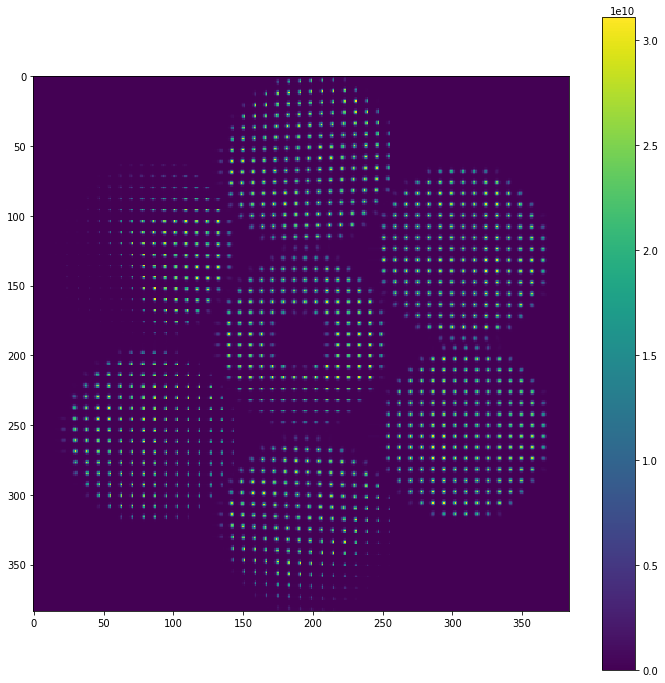

In [79]:
#%%time
gs.timeStamp = 0
wfs.camera.exposureTime = 30#wfsExposureTime
~wfs
+gs
+wfs
fig = plt.figure()
fig.set_size_inches(12,12)
plt.imshow(wfs.camera.ghost_frame[:wfs.N_PX_FRAME,:],interpolation='none',cmap='viridis')
plt.colorbar()

flux = wfs.flux.host()
print " >>> WFS lenslet flux       : %.2f"%(np.median(flux[flux>0]))
print " >>> # of photon per lenslet: %.2f"%(wfs.camera.exposureTime*wfs.camera.photoelectron_gain*gs.nPhoton[0]*(25.5/48)**2)

s = wfs.valid_slopes.host(units='mas').ravel()
print " >>> Numerical centroid rms error: %.2fmas"%(np.std(np.concatenate([s[X.ravel()] for X in C.valid])))
nPhLenslet = wfs.camera.exposureTime*wfs.camera.photoelectron_gain*gs.nPhoton[0]*(25.5/48)**2
print "Theoretical centroid rms error: %.2fmas"%(1e3*seeingArcsec/np.sqrt(2*np.log(2)*nPhLenslet))

### Wavefront sensor long exposure frame

In [ ]:
%%time
gs.timeStamp = 0
gs.samplingTime = samplingTime
wfs.camera.exposureTime = 30#exposureTime
~wfs
gs+=6000
+wfs
fig = plt.figure()
fig.set_size_inches(12,12)
plt.imshow(wfs.ghost_frame[:wfs.N_PX_FRAME,:],interpolation='none',cmap='viridis')
plt.colorbar()

flux = wfs.flux.host()
print " >>> WFS lenslet flux       : %.2f"%(np.median(flux[flux>0]))
print " >>> # of photon per lenslet: %.2f"%(wfs.camera.exposureTime*wfs.camera.photoelectron_gain*gs.nPhoton[0]*(26.0/48)**2)

s = wfs.valid_slopes.host(units='mas').ravel()
print " >>> Numerical centroid rms error  : %.2fmas"%(np.std(np.concatenate([s[X.ravel()] for X in C.valid])))

### TT7 sensor initial frame

In [80]:
#%%time
if TT7_CLASS=="TT7":
    tt7_gs.timeStamp = 0 
    tt7.camera.exposureTime = samplingTime
    +tt7_gs
    +tt7
    fig = plt.figure()
    fig.set_size_inches(15,4)
    plt.imshow(tt7.ghost_frame.T,interpolation='none',cmap='viridis')
    #plt.imshow(tt7.frames[:,:,k],interpolation='none',cmap='viridis')
    plt.colorbar(orientation='horizontal')

    print "WFS total flux     : %.2f"%np.sum(tt7.ghost_frame)
    print "# of photon per sec: %.2f"%(tt7.camera.exposureTime*tt7.camera.photoelectron_gain*tt7_gs.nPhoton*357)

## Integrator gains

In [81]:
wfs_loop_gain = 0.5
tt7_loop_gain = 0.5

## Number of sensor frame delays

In [82]:
wfs_nFrameDelay = 1
tt7_nFrameDelay = 1

In [83]:
VISU = True

In [84]:
C.threshold = 10**-6.5
C.nThreshold

@(CalibrationMatrix)> Updating the pseudo-inverse...


[2, 2, 2, 2, 2, 2, 0]

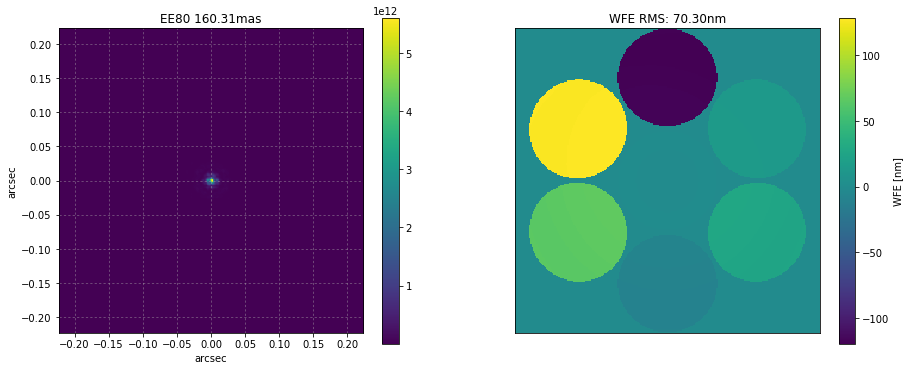



CPU times: user 12min 15s, sys: 37.7 s, total: 12min 53s
Wall time: 12min 36s


In [85]:
%%time
print time.asctime( time.localtime(time.time()) )

gs0.timeStamp = 0
gs.timeStamp = 0
tt7_gs.timeStamp = 0
gs.samplingTime = samplingTime
gs0.samplingTime = samplingTime
tt7_gs.samplingTime = samplingTime

nStep = int(simDuration/samplingTime)
nFrame = int(wfsExposureTime/samplingTime)
print "nStep=%d ; nFrame=%d"%(nStep,nFrame)

ps0_rms = np.zeros(nStep)

tt7_c = np.zeros(14)
tt7_c_eps = np.zeros((14,1+tt7_nFrameDelay))
l = 12+gmt.M1.modes.n_mode*includeBM
c = np.zeros((7*l,1))
c_eps = np.zeros((7*l,1+wfs_nFrameDelay))

tt7_stt = []
stt = []

gmt.M2.motion_CS.log = 0
~imgr
~wfs

if VISU:
    fig,(ax1,ax2) = plt.subplots(ncols=2)
    fig.set_size_inches(15,6)

for k in range(nStep):

    sys.stdout.write("\rT=%.3fs"%(k*samplingTime))
    sys.stdout.flush()
    
    gs0.timeStamp = k*samplingTime
    gs.timeStamp = k*samplingTime
    tt7_gs.timeStamp = k*samplingTime

    stt.append( gs0.segmentsWavefrontGradient()*ceo.constants.RAD2ARCSEC )
    if k>=nFrame:
        #sys.stdout.write("WFS first integration @ T=%.3fs\n"%(k*samplingTime))
        +gs
    +tt7_gs
    +tt7

    #sys.stdout.write("WFE RMS %gnm\n"%(ps0_rms[k]) )

    tt7_s = tt7.get_measurement()
    tt7_stt.append(tt7_s)
    tt7__c_ = np.dot(Mtt7,tt7_s)
    
    tt7_c_eps = np.roll(tt7_c_eps,1,axis=1)
    tt7_c_eps[:,0] = tt7__c_
    
    tt7_c = tt7_c + tt7_loop_gain*tt7_c_eps[:,tt7_nFrameDelay]
    tt7_cp = np.append( tt7_c.reshape(7,2) , np.zeros((7,1)) , axis =1 )
    

    if (k>=2*nFrame) and (k%nFrame)==0:

        sys.stdout.write("\rWFS readout @ T=%.3fs"%(k*samplingTime))
        sys.stdout.flush()
        +wfs
        s = wfs.valid_slopes.host(shape=(wfs.n_valid_slopes,1))
        _c_ = C.dot(s)
    
    if (k>=2*nFrame) and (k%(nFrame+wfs_nFrameDelay))==0:

        c = c + wfs_loop_gain*_c_

    updateGMT(c[:,0],dist,tt7_cp)
    
    if (k>=tt7_nFrameDelay):
        #~imgr
        +gs0
        ps0_rms[k] = gs0.wavefront.rms(-9)
        psf_atm_aco = imgr.frame.host()
        ee80 = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()
        
        if np.isnan(ps0_rms[k]):
            print " >>> NAN ISSUE!!"
            break

        if VISU:
            fwhm8 = (gs0.wavelength/8)*ceo.constants.RAD2ARCSEC
            o = np.linspace(0,1,21)*2*np.pi
            x8 = 0.5*fwhm8*np.cos(o)
            y8 = 0.5*fwhm8*np.sin(o)

            ext = np.array([-1,1,-1,1])*imgr.N_PX_FRAME*0.5*imgr.pixelScaleArcsec(gs0)
            h1 = ax1.imshow(psf_atm_aco,interpolation='none',cmap='viridis',extent=ext)
            ax1.set_title("EE80 %.2fmas"%(ee80))
            #ax1.plot(x8,y8,'w:', linewidth=0.5)
            ax1.grid(ls='dotted',alpha=0.5)
            ax1.set_xlabel('arcsec')
            ax1.set_ylabel('arcsec')
            clb1 = plt.colorbar(h1,ax=ax1)

            h2 = ax2.imshow(gs0.phase.host(units='nm'),interpolation='none',cmap='viridis')
            clb2 = plt.colorbar(h2,ax=ax2,label='WFE [nm]')
            ax2.set_title("WFE RMS: %.2fnm"%ps0_rms[k])
            ax2.set_xticks([])
            ax2.set_yticks([])

            clear_output(wait=True)
            display(fig)
            clb1.remove()
            clb2.remove()

sys.stdout.write("\n\n")
if VISU:
    plt.close()

In [ ]:
print gs0.phaseRms(where='segments',units_exponent=-9)
print gs0.piston(where='segments',units_exponent=-9)
print np.std(gs0.piston(where='segments',units_exponent=-9))

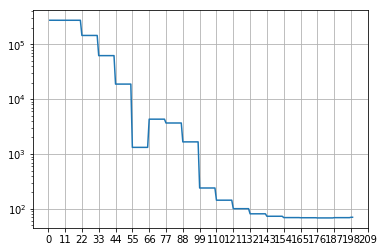

In [86]:
plt.semilogy(ps0_rms)
plt.xticks(range(0,210,11))
plt.grid()

(200, 14)


(0, 30)

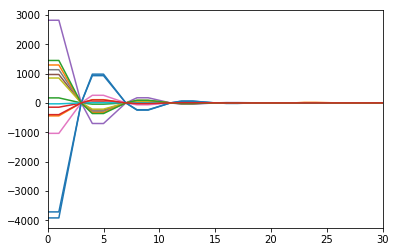

In [87]:
data = [x[None,:] for x in tt7_stt]
data = np.concatenate(data,axis=0)*ceo.constants.RAD2MAS
print data.shape
plt.plot(data);
plt.xlim([0,30])
#plt.ylim([0,1])

In [198]:
tt7_gs.zenith

array([ 0.00174533], dtype=float32)

In [199]:
gs0.zenith

array([ 0.], dtype=float32)

(200, 14)


(0, 30)

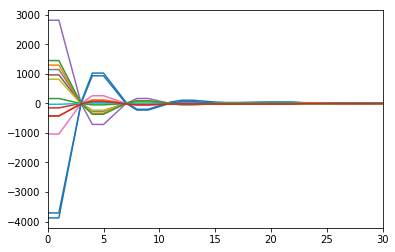

In [88]:
stt[0].shape
data = np.concatenate(stt,axis=1).T
print data.shape
plt.plot(1e3*data)
plt.xlim([0,30])
#plt.ylim([0,1])

In [130]:
W = gs.phase.host(units='nm')
Wa = gs.amplitude.host()

([], <a list of 0 Text yticklabel objects>)

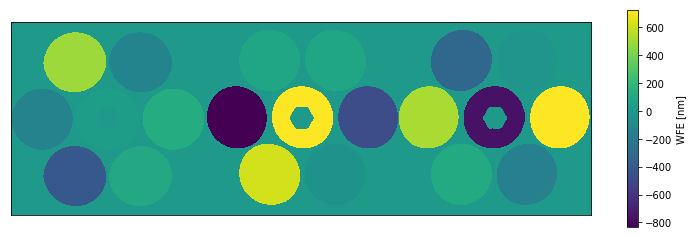

In [133]:
plt.figure(figsize=(13,4))
plt.imshow(np.transpose((W-PS)*Wa*A))
plt.colorbar(label='WFE [nm]')
plt.xticks([])
plt.yticks([])

In [134]:
We = (W-PS)*Wa*A

In [135]:
n = We.shape[1]

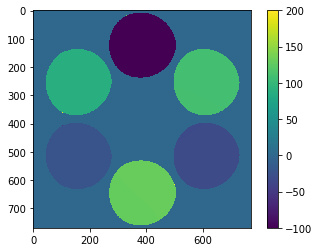

In [136]:
WeS = np.sum(np.dstack([We[k*n:(k+1)*n,:] for k in range(3)]),axis=2)/3
WaS = np.sum(np.dstack([Wa[k*n:(k+1)*n,:] for k in range(3)]),axis=2)
WaS[WaS!=3] = 0
plt.imshow(WeS*WaS/3)
plt.clim([-100,200])
plt.colorbar()

In [132]:
gmt.reset()
+gs
PS = gs.phase.host(units='nm')
A = gs.amplitude.host()

# BATCH: magnitude versus SVD truncation

In [136]:
gs0>>(gmt,)

OPTICAL PATH: ['GMT_MX']


In [137]:
sys.stdout = open('batch.log','wb')

In [ ]:
%%time

for batch in range(11):
    
    print "-------------- BATCH #%d --------------"%batch

    samplingTime = 1/200.0
    wfsExposureTime = 0.05
    simDuration = 4.0
    nStep = int(simDuration/samplingTime)
    nFrame = int(wfsExposureTime/samplingTime)
    print "nStep=%d ; nFrame=%d"%(nStep,nFrame)

    dist = perturbations()
    gmt.reset()
    gmt.M1.motion_CS.euler_angles[:] = dist[0]
    gmt.M1.motion_CS.origin[:]       = dist[2]
    gmt.M1.motion_CS.update()
    gmt.M2.motion_CS.euler_angles[:] = dist[1]
    gmt.M2.motion_CS.origin[:]       = dist[3]
    gmt.M2.motion_CS.update()
    gmt.M1.modes.a[:] = dist[4]
    gmt.M1.modes.update()

    results = {}

    for gs_mag in range(12,20,2):
        
        print "==>> MAG: %d"%gs_mag

        tt7_gs.magnitude = [0]
        gs.magnitude = [gs_mag]*3

        batch_wfs_rms= []

        for C_threshold in 10**np.array([-6.5,-5.5,-4.75]):

            C.threshold = C_threshold
            print C.nThreshold

            print time.asctime( time.localtime(time.time()) )

            gmt.reset()
            gmt.M1.motion_CS.euler_angles[:] = dist[0]
            gmt.M1.motion_CS.origin[:]       = dist[2]
            gmt.M1.motion_CS.update()
            gmt.M2.motion_CS.euler_angles[:] = dist[1]
            gmt.M2.motion_CS.origin[:]       = dist[3]
            gmt.M2.motion_CS.update()
            gmt.M1.modes.a[:] = dist[4]
            gmt.M1.modes.update()

            gs0.timeStamp = 0
            +gs0
            ps0_rms = np.zeros(nStep)
            ps0_rms[0] = gs0.wavefront.rms(-9)
            print ps0_rms[0]

            gs0.timeStamp = 0
            gs.timeStamp = 0
            tt7_gs.timeStamp = 0
            gs.samplingTime = samplingTime
            gs0.samplingTime = samplingTime
            tt7_gs.samplingTime = samplingTime

            tt7_c = np.zeros(14)
            tt7_c_eps = np.zeros((14,1+tt7_nFrameDelay))
            l = 12+gmt.M1.modes.n_mode
            c = np.zeros((7*l,1))
            c_eps = np.zeros((7*l,1+wfs_nFrameDelay))

            tt7_stt = []
            stt = []

            gmt.M2.motion_CS.log = 0
            ~imgr
            ~wfs

            for k in range(nStep):

                sys.stdout.write("\rT=%.3fs"%(k*samplingTime))
                #sys.stdout.flush()

                gs0.timeStamp = k*samplingTime
                gs.timeStamp = k*samplingTime
                tt7_gs.timeStamp = k*samplingTime

                stt.append( gs0.segmentsWavefrontGradient()*ceo.constants.RAD2ARCSEC )
                if k>=nFrame:
                    #sys.stdout.write("WFS first integration @ T=%.3fs\n"%(k*samplingTime))
                    +gs
                +tt7_gs
                +tt7

                #sys.stdout.write("WFE RMS %gnm\n"%(ps0_rms[k]) )

                tt7_s = tt7.get_measurement()
                tt7_stt.append(tt7_s)
                tt7__c_ = np.dot(Mtt7,tt7_s)

                tt7_c_eps = np.roll(tt7_c_eps,1,axis=1)
                tt7_c_eps[:,0] = tt7__c_

                tt7_c = tt7_c + tt7_loop_gain*tt7_c_eps[:,tt7_nFrameDelay]
                tt7_cp = np.append( tt7_c.reshape(7,2) , np.zeros((7,1)) , axis =1 )


                if (k>=2*nFrame) and (k%nFrame)==0:

                    sys.stdout.write("\rWFS readout @ T=%.3fs"%(k*samplingTime))
                    sys.stdout.flush()
                    +wfs
                    s = wfs.valid_slopes.host(shape=(wfs.n_valid_slopes,1))
                    _c_ = C.dot(s)

                if (k>=2*nFrame) and (k%(nFrame+wfs_nFrameDelay))==0:

                    c = c + wfs_loop_gain*_c_

                updateGMT(c[:,0],dist,tt7_cp)

                if (k>=tt7_nFrameDelay):
                    #~imgr
                    +gs0
                    ps0_rms[k] = gs0.wavefront.rms(-9)
                    #psf_atm_aco = imgr.frame.host()
                    #ee80 = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()

            sys.stdout.write("\n\n")
            batch_wfs_rms += [ps0_rms]

        results[gs_mag] = batch_wfs_rms

    np.save('results_wBM%d'%batch,results)

In [208]:
[np.sqrt(np.mean(x[200:]**2)) for x in batch_wfs_rms]

[1028.1502798023198, 728.02785243055268, 1809.9486194239603]

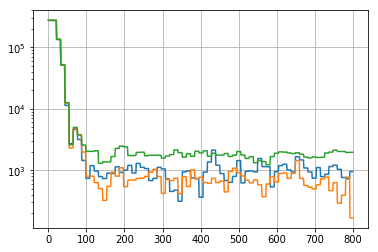

In [209]:
plt.semilogy(batch_wfs_rms[0])
plt.semilogy(batch_wfs_rms[1])
plt.semilogy(batch_wfs_rms[2])
plt.grid()

In [199]:
np.save('batch_wfs_rms_12',batch_wfs_rms)

# BATCH: telescope versus model

In [ ]:
gs0>>(gmt,)
np.random.seed(465)
dist = perturbations()

In [ ]:
sys.stdout = open('batch.log','wb')

In [175]:
#%%time

gs = ceo.Source(**wfs_guide_stars)
gs.fwhm = gs_fwhm
gs.magnitude = [0]*3
gs>>(gmt,wfs)    

zen0 = gs.zenith
azi0 = gs.azimuth
z0 = zen0*np.exp(1j*azi0)
print z0

for batch in range(100):
    
    print "-------------- BATCH #%d --------------"%batch

    samplingTime = 1/200.0
    wfsExposureTime = 0.05
    simDuration = 4.0
    nStep = int(simDuration/samplingTime)
    nFrame = int(wfsExposureTime/samplingTime)
    print "nStep=%d ; nFrame=%d"%(nStep,nFrame)

    gmt.reset()
    gmt.M1.motion_CS.euler_angles[:] = dist[0]
    gmt.M1.motion_CS.origin[:]       = dist[2]
    gmt.M1.motion_CS.update()
    gmt.M2.motion_CS.euler_angles[:] = dist[1]
    gmt.M2.motion_CS.origin[:]       = dist[3]
    gmt.M2.motion_CS.update()
    gmt.M1.modes.a[:] = dist[4]
    gmt.M1.modes.update()

    results = {}

    for gs_mag in range(1):
        
        print "==>> MAG: %d"%gs_mag

        tt7_gs.magnitude = [0]
        gs.magnitude = [gs_mag]*3

        batch_wfs_rms= []

        for C_threshold in 10**np.array([-6.5]):

            C.threshold = C_threshold
            print C.nThreshold

            print time.asctime( time.localtime(time.time()) )

            gmt.reset()
            gmt.M1.motion_CS.euler_angles[:] = dist[0]
            gmt.M1.motion_CS.origin[:]       = dist[2]
            gmt.M1.motion_CS.update()
            gmt.M2.motion_CS.euler_angles[:] = dist[1]
            gmt.M2.motion_CS.origin[:]       = dist[3]
            gmt.M2.motion_CS.update()
            gmt.M1.modes.a[:] = dist[4]
            gmt.M1.modes.update()

            gs0.timeStamp = 0
            +gs0
            ps0_rms = np.zeros(nStep)
            ps0_rms[0] = gs0.wavefront.rms(-9)
            print ps0_rms[0]

            gs0.timeStamp = 0
            gs.timeStamp = 0
            tt7_gs.timeStamp = 0
            gs.samplingTime = samplingTime
            gs0.samplingTime = samplingTime
            tt7_gs.samplingTime = samplingTime

            tt7_c = np.zeros(14)
            tt7_c_eps = np.zeros((14,1+tt7_nFrameDelay))
            l = 12+gmt.M1.modes.n_mode
            c = np.zeros((7*l,1))
            c_eps = np.zeros((7*l,1+wfs_nFrameDelay))

            tt7_stt = []
            stt = []

            gmt.M2.motion_CS.log = 0
            ~imgr
            ~wfs
            
            #----------------------------------
            # __ GS LOC. RANDN ERROR __
            dz = np.random.randn(3)*0.5*ceo.constants.ARCSEC2RAD/3
            da = np.random.rand(3)*2*np.pi
            z = z0 + dz*np.exp(1j*da)
            gs.updateDirections(np.array(np.abs(z),dtype=np.single),
                                np.array(np.angle(z),dtype=np.single))
            #----------------------------------

            for k in range(nStep):

                sys.stdout.write("\rT=%.3fs"%(k*samplingTime))
                #sys.stdout.flush()

                gs0.timeStamp = k*samplingTime
                gs.timeStamp = k*samplingTime
                tt7_gs.timeStamp = k*samplingTime

                stt.append( gs0.segmentsWavefrontGradient()*ceo.constants.RAD2ARCSEC )
                if k>=nFrame:
                    #sys.stdout.write("WFS first integration @ T=%.3fs\n"%(k*samplingTime))
                    +gs
                +tt7_gs
                +tt7

                #sys.stdout.write("WFE RMS %gnm\n"%(ps0_rms[k]) )

                tt7_s = tt7.get_measurement()
                tt7_stt.append(tt7_s)
                tt7__c_ = np.dot(Mtt7,tt7_s)

                tt7_c_eps = np.roll(tt7_c_eps,1,axis=1)
                tt7_c_eps[:,0] = tt7__c_

                tt7_c = tt7_c + tt7_loop_gain*tt7_c_eps[:,tt7_nFrameDelay]
                tt7_cp = np.append( tt7_c.reshape(7,2) , np.zeros((7,1)) , axis =1 )


                if (k>=2*nFrame) and (k%nFrame)==0:

                    sys.stdout.write("\rWFS readout @ T=%.3fs"%(k*samplingTime))
                    sys.stdout.flush()
                    +wfs
                    s = wfs.valid_slopes.host(shape=(wfs.n_valid_slopes,1))
                    _c_ = C.dot(s)

                if (k>=2*nFrame) and (k%(nFrame+wfs_nFrameDelay))==0:

                    c = c + wfs_loop_gain*_c_

                updateGMT(c[:,0],dist,tt7_cp)

                if (k>=tt7_nFrameDelay):
                    #~imgr
                    +gs0
                    ps0_rms[k] = gs0.wavefront.rms(-9)
                    #psf_atm_aco = imgr.frame.host()
                    #ee80 = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()

            sys.stdout.write("\n\n")
            batch_wfs_rms += [ps0_rms]

        results[gs_mag] = [dz,da,batch_wfs_rms]

    np.save('results_telescopeVsModel%d'%batch,results)

OPTICAL PATH: ['GMT_MX', 'ShackHartmann']
[ 0.00174533+0.j        -0.00087266+0.0015115j -0.00087266-0.0015115j]
-------------- BATCH #0 --------------
nStep=800 ; nFrame=10
==>> MAG: 0
@(CalibrationMatrix)> Updating the pseudo-inverse...
[2, 2, 2, 2, 2, 2, 0]
Mon Mar 20 20:58:54 2017
334904.558258
T=3.995s

-------------- BATCH #1 --------------
nStep=800 ; nFrame=10
==>> MAG: 0
@(CalibrationMatrix)> Updating the pseudo-inverse...
[2, 2, 2, 2, 2, 2, 0]
Mon Mar 20 21:05:48 2017
334904.558258
T=3.995s

-------------- BATCH #2 --------------
nStep=800 ; nFrame=10
==>> MAG: 0
@(CalibrationMatrix)> Updating the pseudo-inverse...
[2, 2, 2, 2, 2, 2, 0]
Mon Mar 20 21:12:41 2017
334904.558258
T=0.490s

KeyboardInterrupt: 

In [191]:
data_file = 'results_telescopeVsModel'
all_data = np.zeros(2)

#plt.figure()

ezen = []
eazi = []

for k in range(2):
    results = np.load('%s%d.npy'%(data_file,k))

    keys = results[()].keys()
    keys.sort()

    data = []
    for key in keys:
        #print key
        ezen += [results[()][key][0]]
        eazi += [results[()][key][1]]
        batch_wfs_rms = results[()][key][2]
        #plt.plot(batch_wfs_rms[0])
        #print [np.sqrt(np.mean(x[200:]**2))  for x in batch_wfs_rms]
        data += [np.sqrt(np.mean(x[200:]**2))  for x in batch_wfs_rms]

    all_data[k] = np.array(data)
#plt.xlim([0,100])

In [192]:
print [x*ceo.constants.RAD2ARCSEC for x in ezen] 
print [x*180/np.pi for x in eazi] 

[array([ 0.0303212 ,  0.22923183, -0.17337694]), array([-0.05208768,  0.00492441, -0.17842097])]
[array([  93.49636348,   25.88837142,  125.66063396]), array([ 297.82094379,   60.97622977,  350.83728809])]


In [193]:
all_data

array([ 69.95702541,  61.70857132])